# Cancer Cell Classification: EDA, Baseline Model, Metrics, and Grad-CAM

This notebook explores the dataset, trains a CNN classifier, evaluates with detailed metrics, and visualizes Grad-CAM heatmaps.

## 1. Imports and Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except ImportError:
    print("Please install grad-cam: pip install grad-cam")

## 2. Dataset Overview

benign: 772 images
malignant: 207 images


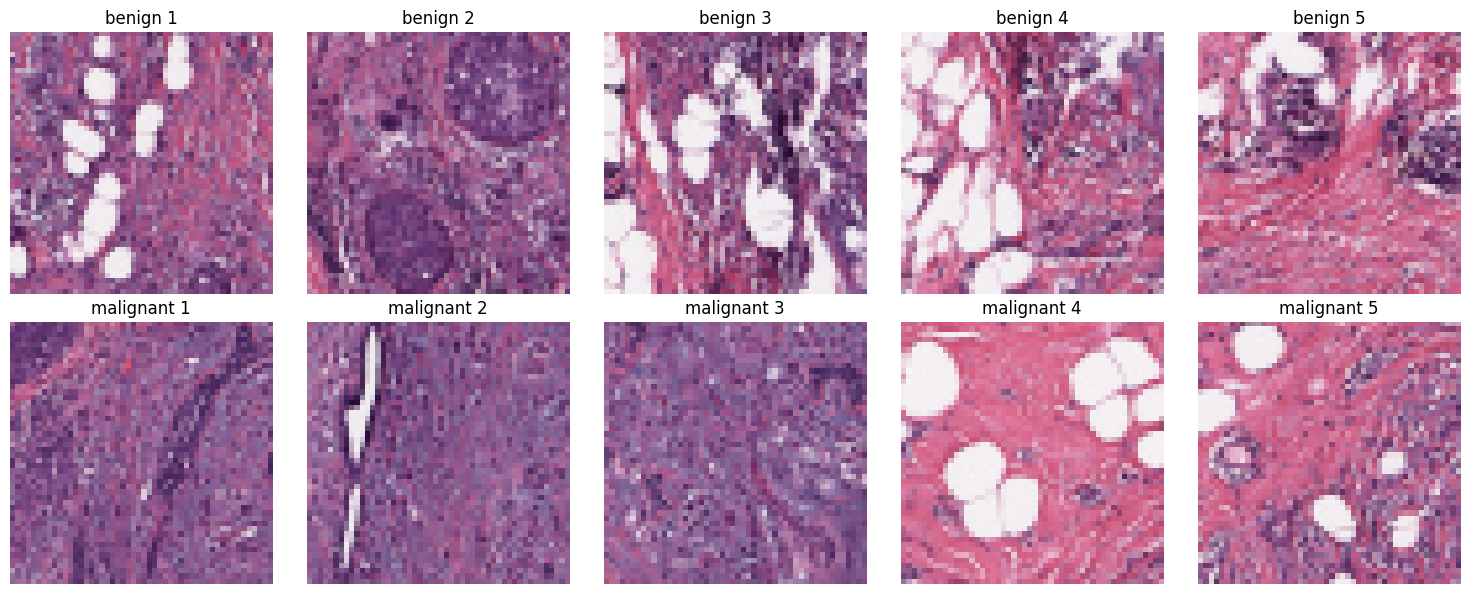

In [2]:
data_dir = '../data'  # Adjust if needed
classes = ['benign', 'malignant']

# Count images in each class
for cls in classes:
    img_list = os.listdir(os.path.join(data_dir, cls))
    print(f"{cls}: {len(img_list)} images")

# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, cls in enumerate(classes):
    img_list = os.listdir(os.path.join(data_dir, cls))[:5]
    for j, img_name in enumerate(img_list):
        img_path = os.path.join(data_dir, cls, img_name)
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].set_title(f"{cls} {j+1}")
        axes[idx, j].axis('off')
plt.tight_layout()
plt.show()

## 3. PyTorch Dataset and Loader

In [4]:
class CancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.data = []
        for label, class_name in enumerate(['benign', 'malignant']):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.data.append((img_path, label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path  # include path for Grad-CAM


## 4. Data Transforms, Loaders, and Splitting

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = CancerDataset(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)
all_val_indices = val_ds.indices if hasattr(val_ds, 'indices') else list(range(train_size, train_size + val_size))

## 5. Baseline Model (Transfer Learning)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

C:\Users\nmlek\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nmlek\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 6. Training Loop

In [8]:
num_epochs = 6
train_losses, val_accuracies = [], []
best_model_state = None
best_f1 = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Accuracy = {acc:.2%}, F1 = {f1:.2f}")
    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict().copy()

Epoch 1: Train Loss = 0.4289, Val Accuracy = 74.49%, F1 = 0.00
Epoch 2: Train Loss = 0.3885, Val Accuracy = 74.49%, F1 = 0.00
Epoch 3: Train Loss = 0.3497, Val Accuracy = 88.27%, F1 = 0.79
Epoch 4: Train Loss = 0.3060, Val Accuracy = 87.76%, F1 = 0.77
Epoch 5: Train Loss = 0.3099, Val Accuracy = 88.27%, F1 = 0.78
Epoch 6: Train Loss = 0.3048, Val Accuracy = 74.49%, F1 = 0.00


## 7. Training Curves

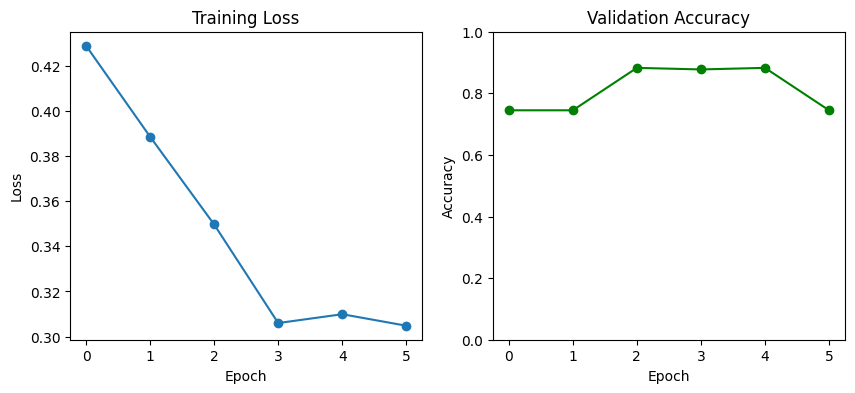

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## 8. Detailed Evaluation Metrics (Accuracy, Precision, Recall, F1, ROC-AUC, PR Curve)


Accuracy: 74.49%
F1 Score: 0.00
ROC AUC: 0.15

Classification Report:
               precision    recall  f1-score   support

      benign       0.74      1.00      0.85       146
   malignant       0.00      0.00      0.00        50

    accuracy                           0.74       196
   macro avg       0.37      0.50      0.43       196
weighted avg       0.55      0.74      0.64       196

Confusion Matrix:
 [[146   0]
 [ 50   0]]


C:\Users\nmlek\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nmlek\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nmlek\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

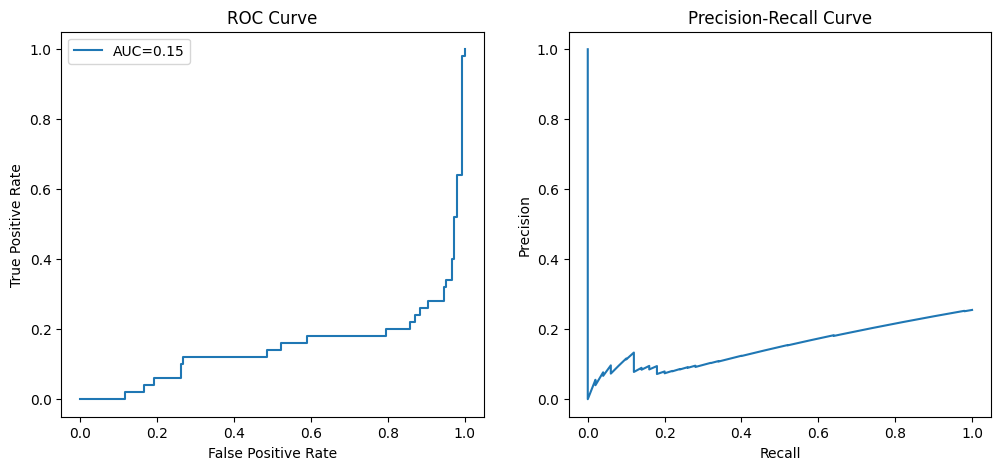

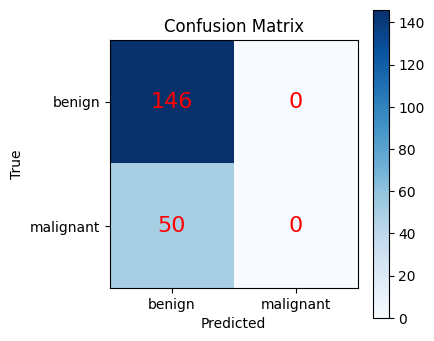

In [10]:
# Restore best model
model.load_state_dict(best_model_state)
model.eval()
all_labels, all_preds, all_probs, all_img_paths = [], [], [], []
with torch.no_grad():
    for inputs, labels, img_paths in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.flatten())
        all_probs.extend(probs.flatten())
        all_img_paths.extend(img_paths)

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=classes)
auc = roc_auc_score(all_labels, all_probs)
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

print(f"\nAccuracy: {acc:.2%}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {auc:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)

# Plot ROC and Precision-Recall
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC={auc:.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)
plt.colorbar()
plt.show()

## 9. Grad-CAM Visualization for Model Interpretability

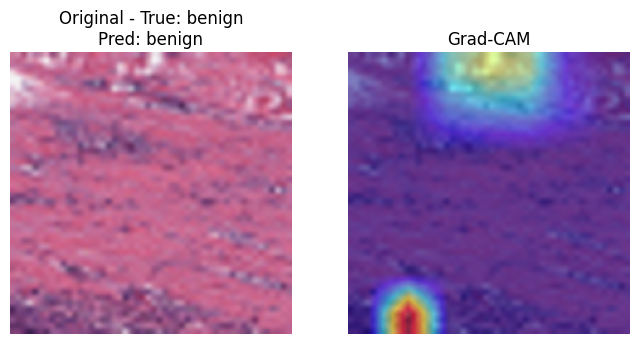

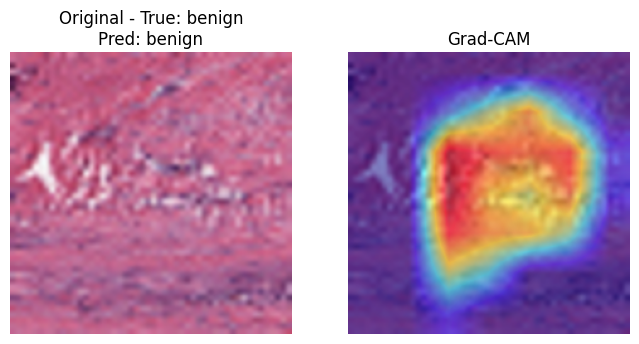

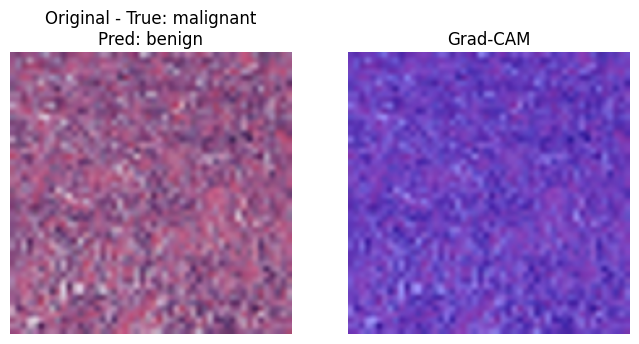

In [11]:
# Grad-CAM for a few validation images
if 'GradCAM' in globals():
    num_cam = min(3, len(all_img_paths))
    indices_to_show = np.random.choice(len(all_img_paths), num_cam, replace=False)
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    for idx in indices_to_show:
        img_path = all_img_paths[idx]
        label = all_labels[idx]
        pred = all_preds[idx]
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=img_tensor)[0]
        img_np = np.array(img.resize((224,224))) / 255.0
        visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title(f"Original - True: {classes[int(label)]}\nPred: {classes[int(pred)]}")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(visualization)
        plt.title("Grad-CAM")
        plt.axis('off')
        plt.show()
else:
    print("[INFO] Grad-CAM is not installed. Please install with `pip install grad-cam` to see model interpretability visualizations.")